# Portfolio Optimization with Hybrid HHL Algorithm

## 1. Introduction - portfolio optimization
**Below we briefly present the problem at hand, as well as its mathematical formulation**

Modern portfolio optimization [[1](#PortfolioWiki)] is the process of allocating a portfolio of financial assets optimally, according to some predetermined goal. Usually, the goal is to maximize the potential return while minimizing the financial risk of the portfolio. In similar to many other real-world problems, one can express the portfolio optimization problem as a set of linear equations. In this demo, we show how a quantum linear solver, the HHL algorithm [[2](#HHL)], or its hybrid variance [[3](#Hybrid-HHL)], can be used to solve this problem. We demonstrate how using functional modeling can be leveraged for constructing different models and obtaining different quantum programs for a given set of constraints.

*In this demo we focus on the case of continuous variable for the allocation vector. The scenario of discrete allocation falls into the domain of Combinatorial Optimization Problems, for which one can employ the QAOA (Quantum Approximate Optimization Ansatz) approach.* 

### 1.1 Portfolio optimization problem as a linear equation

As a first step, we have to model the problem mathematically:

- A portfolio is built from a pool of $N$ financial assets.
- The assets' return values are random variables, whose statistical properties are represented by the expected return vector $\vec{\mu} \in \mathbb{R}^N$ and a covariance  matrix $\Sigma\in \mathbb{R}^N\times\mathbb{R}^N$.
- The prices of the assets today are represented by the prices vector $\vec{p}\in \mathbb{R}^N$.
- The portfolio has an allocation vector $\vec{w} \in \mathbb{R}^N$, representing the weight of each asset in the portfolio ---  *this is the variable we would like to find*.
- Finally, the portfolio problem has two constants: a desired total return $R$, and a total budget $B$.

The task is to find a solution for the allocation vector $\vec{w}$ which minimizes the risk
\begin{equation}
\min_{\vec{w}} \vec{w}^T\cdot \Sigma \cdot \vec{w},
\end{equation}
under the constraints of
\begin{eqnarray}
    \text{getting the desired total return: } R&=\vec{\mu}^T\cdot\vec{w},\\
    \text{satisfying the total known budget: } B&=\vec{p}^T\cdot\vec{w}
\end{eqnarray}

Writing this problem as a constrained minimization problem in a continuous space, we get a set of linear equations:
\begin{equation}
    \begin{pmatrix}
        0 & 0 & \vec{\mu}^T \\
        0 & 0 & \vec{p}^T \\
        \vec{\mu} & \vec{p} & \Sigma \\
    \end{pmatrix}
    \begin{pmatrix}
        \nu_1 \\
        \nu_2 \\
        \vec{w} \\
    \end{pmatrix}
    =
    \begin{pmatrix}
        R \\
        B \\
        \vec{0} \\
    \end{pmatrix}, \quad (1)
\end{equation}
where $\nu_{1,2}$ are Lagrange multipliers.

**comment**: one can rescale the problem and set the total budget to $B=1$.

Equation (1) is of the form of a linear equation:
\begin{equation}
A\cdot \vec{x} = \vec{b} \quad (2)
\end{equation}

## 2. The HHL algorithm
**Below we briefly present the fundamental HHL algorithm, and its hybrid variance**

### 2.1 The basic HHL algorithm

The HHL algorithm [[2](#HHL)] (after Harrow, Hassidim, and Lloyd) is a quantum linear solver, treating problems which can be defined by Eq. (1). The basic implementation assumes that the $\vec{b}$ is a normalized vector $|\vec{b}|=1$ of size $2^n$, and that $A$ is an Hermitian matrix of size $2^n\times 2^n$, whose eigenvalues are in the interval $[0,1)$. For the mathematical introduction we will follow these assumptions, whereas in the following sections we show how to tweek the quantum model in order to relax them.

The basic HHL algorithm contains 4 functional blocks:

1.  **State Preparation for the vector $\vec{b}$**: Let us assume that $\vec{b}$ is of size $2^n$, then:
$$
ֿ|0\rangle_n \xrightarrow[{\rm SP}]{} \sum^{2^n-1}_{i=0}b_i|i\rangle_n. \quad (3)
$$
2. **Quantum Phase Estimation (QPE) for the unitary $e^{2\pi iA}$**: This quantum block approximates the eigenvalues of the matrix $A$, $\{\lambda_i\}^{2^n}_{i=1}$, into a register of size $m$. If we write the vector $\vec{b}$ in the basis of eigenvectors of $A$, $\sum^{2^n-1}_{i=0}b_i|i\rangle_n = \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n$, then the QPE stage gives
$$
|0\rangle_m \sum^{2^n-1}_{j=0}\beta_j|\psi_j\rangle_n \xrightarrow[{\rm QPE}(e^{2\pi i A})]{}  \sum^{2^n-1}_{j=0}\beta_j |\tilde{\lambda}_j\rangle_m |\psi_j\rangle_n, \quad (4)
$$
where $\tilde{\lambda}=\frac{1}{2^m}\sum^{2^m-1}_{k=0}\tilde{\lambda}^{(k)}2^k$ with $\tilde{\lambda}^{(k)}$ being the state of the $k$-th qubit. Thus, $m$ is the precision of the binary representation of $\tilde{\lambda}$, which in turn is an approximation of the actual eigenvalue of $A$, $\lambda$.
3. **Eigenvalue Inversion:** This quantum block adds an extra qubit
$$
|0\rangle\sum^{2^n-1}_{j=0}\beta_j |\tilde{\lambda}_j\rangle_m |\psi_j\rangle_n \xrightarrow[{\rm Eig. \, Inversion}]{}
|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\tilde{\lambda}_j}\beta_j  |\tilde{\lambda}_j\rangle_m|\psi_j\rangle_n\right)+
|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}\beta_j  |\tilde{\lambda}_j\rangle_m |\psi_j\rangle_n\right), \quad (5)
$$
where $C$ is a normalization factor which gurrentees that the amplitudes are not larger than 1.
4. **Inverese QPE for the unitary $e^{2\pi iA}$**: This operation acts on the QPE register of size $m$ and aims to return the phase registers to zero. The final state is:
$$
\tag{6} |0\rangle_m|1\rangle\left(\sum^{2^n-1}_{j=0}\frac{C}{\tilde{\lambda}_j}\beta_j |\psi_j\rangle_n\right)+
|0\rangle_m|0\rangle\left(\sum^{2^n-1}_{j=0}\sqrt{1-\frac{C^2}{\tilde{\lambda}^2_j}}\beta_j  |\psi_j\rangle_n\right).
$$

#### 2.1.1 Getting the result - a swap-test example
Looking at Eq. (6) we can see that the result vector $\vec{x}$ is coupled to the indicator state $|1\rangle$  (up to normalization with the known constant $C$):
$$
\sum^{2^n-1}_{j=0} \frac{C}{\lambda_j}\beta_j  \vec{\psi_j} = C\vec{x}. \quad (7)
$$
In order to obtain the solution from the quantum circuit we must measure the complete statevector, however, this exponential readout procedure halts quantum advantage. In the framework of portfolio optimization, it was suggested that one can use a *swap-test* [[4](#SwapWiki)] to compare the result to some guess of the solution. Let us write the quantum state at the final stage of the HHL algorithm, Eq. (6), as $C|\vec{x}||1\rangle|\hat{\tilde{x}}\rangle_{n}+\alpha|0\rangle |\zeta\rangle_{n}$, where we neglect the QPE register, and $\alpha|\zeta\rangle$ is some non-normalized state.

For the swap-test we add an extra test qubit $|0\rangle_{\rm test}$ and we need to prepare a quantum register with the guessed solution $|\hat{y}\rangle$. Applying the swap-test gives the final state:
$$
\frac{C|\vec{x}|}{2}|1\rangle\left[ |0\rangle_{\rm test}\left(|\hat{\tilde{x}},\hat{y}\rangle_{2n}+|\hat{y},\hat{\tilde{x}}\rangle_{2n} \right)+ |1\rangle_{\rm test}\left(|\hat{\tilde{x}},\hat{y}\rangle_{2n}-|\hat{y},\hat{\tilde{x}}\rangle_{2n} \right) \right] + \text{non-interesting state} \quad (8)
$$
From the above equation we find that the probability of measuring 1 on the HHL indicator qubit and 0 on the test qubit is
$$
P(\text{test}=0,\text{indictor}=1) = \frac{C^2|\vec{x}|^2}{2} \left(1 + |\langle \hat{\tilde{x}}|\hat{y}\rangle|^2 \right)=
\frac{P(\text{indictor}=1)}{2} \left(1 + |\langle \hat{\tilde{x}}|\hat{y}\rangle|^2 \right). \quad (9)
$$
From this equation one can determine the desired overlap $|\langle \hat{\tilde{x}}|\hat{y}\rangle|^2 $.

### 2.2 A hybrid approach

The hybrid approach [[3](#Hybrid-HHL)] comes to facilitate the Eigenvalue Inversion function which is not easy to implement. This quantum block can be obtained using multi-controlled RY rotations:
$$
\tag{10}
|0\rangle|\lambda\rangle_m \xrightarrow[{\rm multi-controlled-RY}(2\arcsin(C/\lambda))]{}
\frac{C}{\lambda}|1\rangle|\lambda\rangle_m+\sqrt{1-\frac{C^2}{\lambda^2}}|0\rangle|\lambda\rangle_m.
$$
However, to apply this procedure we should have a quantum block which caclulates $\arcsin{C/\lambda}$, and such general arithmetics requires many qubits. Another approach is to use a generic amplitude loading for the function $f(x)=C/x$, but this procedure contains exponential number, $2^m$, of multi-controlled rotations (the gray-code approch might reduce the gate count by some factor, but the total gate count is still $O(2^m)$).

The hybrid approach containes three steps:
1. **QPE of $e^{2\pi i A}$ on the State Preparation of $\vec{b}$**:  This is simply the first two steps of the HHL algorithm, corresponding to the final state $\sum^{2^n-1}_{j=0}\beta_j |\tilde{\lambda}_j\rangle_m |\psi_j\rangle_n$.
2. **Classical post-process**: We analyze the results in the context of the following two facts: (i) The matrix $A$ has $2^n$ eigenvalues, whereas the QPE gives approximation of these over $2^m$ different values. (ii) Not all the eigenvalues of $A$ are relevant to the solution, but only eigenvalues such that $\beta_j/\lambda_j>\epsilon$, with $\epsilon$ being some user-defined tolarance. Based on these two points we can try to find a set of relevant eigenvalues $\{\tilde{\lambda}_s\}^r_{s=1}$ to our problem.
3. **A full HHL routine**: We now apply a usual HHL algorithm, where the Eigenvalue Inversion block is implemented by hard-coded multi-controlled-RY rotation according to the specific values found in the previous step. Moreover, we can represent the relevant eigenvalues with a smaller binary represantation of size $m'<m$. Then in the HHL we use a QPE with this smaller size, and apply the controlled rotations with angles which are calculated with higher precision.

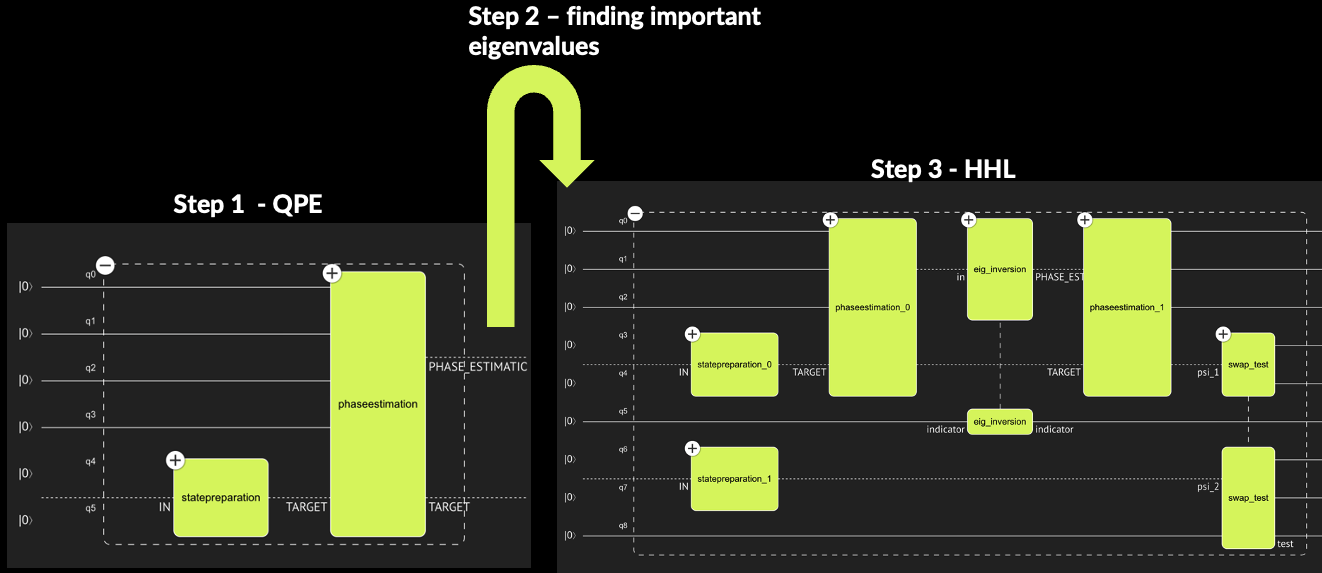

## 3. Eigenvalue Inversion Quantum functions

We define two eigenvalue inversion functions, one which rotates over all eigenvalues, and another rotating on a reduced set of these. In addition, we take into account an affine transformation of the matrix, and its resulting transformation on the eigenvalues. The affine transformation is necessary as the QPE is applied on a matrix whose eigenvalues are in $[0,1)$. We can define a transformation $A = \gamma A_{\rm qpe}+\delta$ with a rescaling factor $\gamma$ and a shift value $\delta$. The eigenvalues of the original matrix are transformed in a similar way. In the HHL algorithm, we use QPE to store the eigenvalues of the transformed matrix $A_{\rm qpe}$, but perform eigenvalue inversion for the original matrix $A$. Thus, inversion of an eigenvalue corresponds to the following operation:
$$
|0\rangle|\lambda\rangle_m \xrightarrow[{\rm eig-inversion}]{}
\frac{C}{\gamma\lambda+\delta}|1\rangle|\lambda\rangle_m+\sqrt{1-\left(\frac{C}{\gamma\lambda+\delta}\right)^2}|0\rangle|\lambda\rangle_m.
$$
The normalization parameter $C$ gurentees that the amplitudes' norm is $\leq 1$. 

### 3.1. Full eigenvalue inversion function

First, we define a quantum function that performs a simple eigenvalue inversion with Classiq built-in amplitude loading function, `assign_amplitude_table`.

In [1]:
from classiq import *


@qfunc
def simple_eig_inv(
    gamma: float,
    delta: float,
    c_param: float,
    phase: QNum,
    indicator: Output[QBit],
):
    allocate(1, indicator)
    assign_amplitude_table(
        lookup_table(lambda p: np.clip(c_param / ((gamma * p) + delta), -1, 1), phase),
        phase,
        indicator,
    )

### 3.2. Partial eigenvalue inversion, with prescribed values

Here, we apply hard-coded controlled rotations, as described in Sec. 2.2. Moreover, we take into account a situation where the rotation angles are given with higher precision than the eigenvalues stored in the phase variable returning from the QPE.

In [2]:
from classiq.qmod.symbolic import asin, floor


@qfunc
def reduced_hardcoded_eig_inversion(
    gamma: CReal,
    delta: CReal,
    c_param: CReal,
    eigs: CArray[CReal],  # list of eigenvalues to rotate
    phase: QNum,
    indicator: Output[QBit],
) -> None:

    allocate(1, indicator)
    integer_phase = QNum("integer_phase", phase.size, False, 0)
    bind(phase, integer_phase)
    repeat(
        eigs.len,
        lambda index: control(
            integer_phase
            == floor(
                eigs[index] * 2**phase.size
            ),  # currently control only supports int
            lambda: RY(2 * asin(c_param / (gamma * eigs[index] + delta)), indicator),
        ),
    )
    bind(integer_phase, phase)

## 4. Taking a specific example

We consider a specific portfolio optimization example for the demonstration. We focus on a simple case of 2 assets, and define the corresponding set of linear equations (a $2\times 2$ problem is represented by `n_unitary=2` qubits, for more complex examples see Sec. 8):

In [3]:
import numpy as np

N_ASSETS = 2  # number of assets
COVARIANCE_MAT = np.array(
    [
        [
            0.2,
            0.04,
        ],
        [0.04, 0.4],
    ]
)
RETURNS_VEC = np.array([0.04, 0.64])
PRICES_VEC = np.array([1, 0.8])
TOTAL_BUDGET = 1
EXPECTED_RETURN = 2.4

b_vec = np.concatenate(
    [np.array([EXPECTED_RETURN, TOTAL_BUDGET]), np.zeros(N_ASSETS)]
).T
a_mat = np.block(
    [
        [np.zeros([1, 2]), RETURNS_VEC],
        [np.zeros([1, 2]), PRICES_VEC],
        [
            RETURNS_VEC.reshape(N_ASSETS, 1),
            PRICES_VEC.reshape(N_ASSETS, 1),
            COVARIANCE_MAT,
        ],
    ]
)

n_unitary = N_ASSETS + 2  # matrix size

### 4.1 Preparing the vector $\vec{b}$

We shall normalize the vector $\vec{b}$ before loading it into a quantum register. In addition, the user can control the functional error of this function block.

In [4]:
b_vec_norm = np.linalg.norm(b_vec)
normalized_b_vec = (b_vec / b_vec_norm).tolist()
SP_ERROR = 0.0

### 4.2 Calculating the maximal eigenvalue

As we will see below, the HHL algorithm assumes that we have some bound on the maximal eigenvalue (in absolute value) of the matrix. For the sake of demonstration, we will perform a full classical eigenvalue decomposition. This also serves us for verifying the QPE in Step 1.

In [5]:
w, v = np.linalg.eig(a_mat)
w_max = max(np.abs(w))

### 4.3 Preparing the unitary from the matrix $A$ for the Quantum Phase Estimation

The QPE function gets a phase quantum variable, whose size refers to the precision of the eigenphases estimations. We set it with to 4. (note that this number corresponds to the condition number of the matrix $\kappa \equiv \lambda_{max}/\lambda_{min}$).

In [6]:
QPE_SIZE = 4

As explained in Sec. 3, we have to classically transform our matrix to have eigenvalues in $[0,1)$, and apply an inverse transformation when performing the eigenvalue inversion block. We take the following matrix transformation:
$$
A_{\rm qpe} = \left(1-2^{\rm qpe-size}\right)(A+\lambda_{max})/2\lambda_{max}.
$$

In [7]:
import scipy

mat_shift = w_max  # assures only positive eivenvalues
mat_rescaling = (1 - 1 / 2**QPE_SIZE) / (
    2 * w_max
)  # assures eigenvalues in [0,1-1/2^QPE_SIZE]

a_mat_qpe = (a_mat + np.identity(n_unitary) * mat_shift) * mat_rescaling
# rescaled and shifted matrix

w_min = w_max / (
    2**QPE_SIZE - 1
)  # this is the minimal eigenvalue which can be resolved by the QPE

print("the maximal eigenvalue found:", w_max)
print("the minimal resolved eigenvalue with qpe of size", QPE_SIZE, ":", w_min)

the maximal eigenvalue found: 1.547651922176089
the minimal resolved eigenvalue with qpe of size 4 : 0.10317679481173926


**The transformation to $A_{\rm qpe}$, whose eigenvalues are in $[0,1)$, implies the inverse transformation for the eigenvalue inversion with: $\gamma=1/$ `mat_rescaling`, $\delta=-$ `mat_shift`, and $C=$`w_min` respectively**.

## 5. Solving with a Hybrid HHL

---

For the demonstration we use the exact unitary, namely, we calculate classically $e^{2\pi i A_{\rm qpe}}$. We then use the built-in quantum function `unitary` for decomposing the unitary into quantum gates. Note that this procedure is not scalable, as the decomposition is exponential in the number of qubits. In addition, the classical calculation is equivalent to solving the linear equation. Yet, this approach is good for small-scale problems.

*One relevant way to implement the unitary is with Hamiltonian simulation, see Sec. (8)*
                                                                         

---

In [8]:
unitary_mat = scipy.linalg.expm(1j * 2 * np.pi * a_mat_qpe).tolist()

### 5.1. Step 1: a QPE applied on the StatePreparation of $\vec{b}$

Building a quantum model, synthesizing to a quantum program, and executing to get the results

In [9]:
NUM_SHOTS = 2048
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR
)


@qfunc
def main(phase_result: Output[QNum[QPE_SIZE, False, QPE_SIZE]]) -> None:
    state = QArray("state")
    allocate(QPE_SIZE, False, QPE_SIZE, phase_result)
    prepare_amplitudes(normalized_b_vec, SP_ERROR, state)
    qpe(unitary=lambda: unitary(unitary_mat, state), phase=phase_result)
    drop(state)


qmod_qpe = create_model(main)
qmod_qpe = set_execution_preferences(
    qmod_qpe,
    ExecutionPreferences(num_shots=NUM_SHOTS, backend_preferences=backend_preferences),
)

In [10]:
from classiq import execute, synthesize

qprog_qpe = synthesize(qmod_qpe)
results = execute(qprog_qpe).result()
res_qpe = results[0].value

We can visualize the circuit

In [11]:
show(qprog_qpe)

Quantum program link: https://platform.classiq.io/circuit/36pbc2hFJmpoA5SgVeJVJW2anPQ


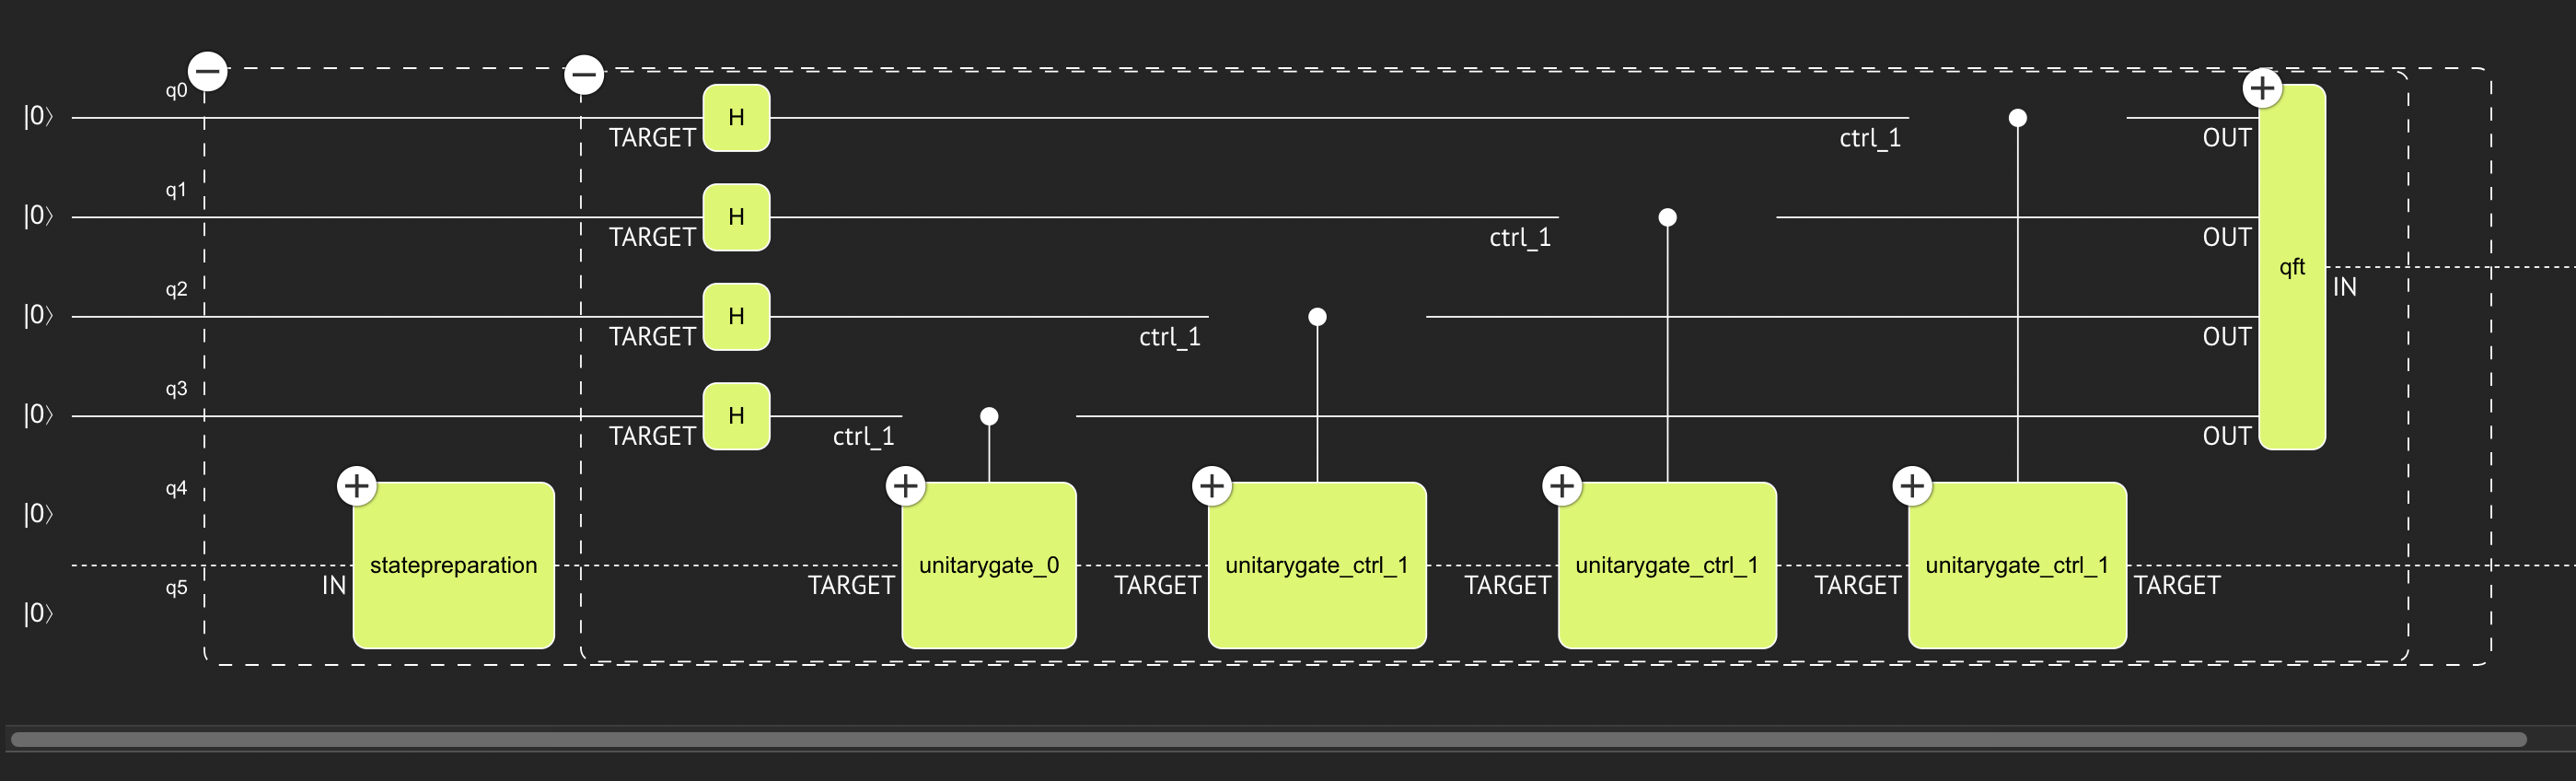

### 5.2. Step 2: Post-Processing the results to get data for the eigenvalue inversion

To analyze the results we generate the following 4 lists:
* `qpe_eigs`: the values of the QPE eigenvalues $\lambda_{\rm qpe}$,
* `original_eigs`: the values of the original matrix eigenvalues,
* `eigs_prob`: the probability of each eigenvalue, this corresponds to $\beta^2_j$ in Eq. (4).
* `projected_x`: the effect of each phase on the solution $\vec{x}$, given by $\beta_j/\lambda_j$.

In [12]:
qpe_eigs = np.array([sample.state["phase_result"] for sample in res_qpe.parsed_counts])
original_eigs = np.array([mat_rescaling ** (-1) * eig - mat_shift for eig in qpe_eigs])
eigs_prob = np.array([sample.shots / NUM_SHOTS for sample in res_qpe.parsed_counts])
projected_x = np.sqrt(eigs_prob) / original_eigs

Let us examine the measured phases and their contribution to the solution vector $\vec{x}$.

Text(0.5, 0, '$\\lambda$')

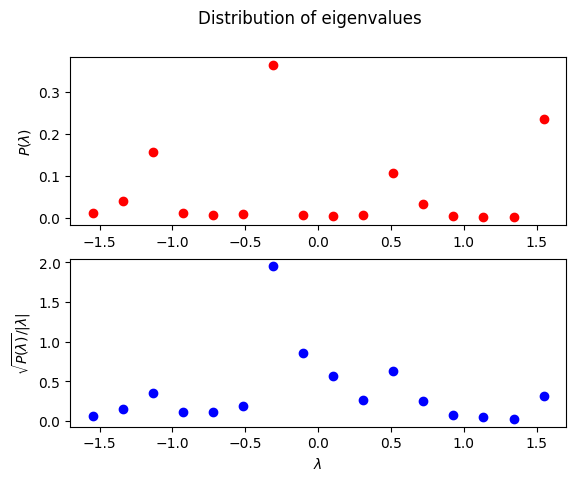

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle("Distribution of eigenvalues")
axs[0].plot(original_eigs, eigs_prob, color="red", marker="o", linestyle="None")
axs[0].set_ylabel("$P(\\lambda)$")
axs[1].plot(
    original_eigs, np.abs(projected_x), color="blue", marker="o", linestyle="None"
)
axs[1].set_ylabel("$\\sqrt{P(\\lambda)}/|\\lambda|$")
axs[1].set_xlabel("$\\lambda$")

What can we learn from the data?

We are dealing with a $4 \times 4$ matrix, thus it has only 4 eigenvalues. The QPE tries to approximate this with binary representation of size `QPE_SIZE`=4, resulting in $2^4=16$ values. We can take the two most significant eigenvalues for which we will apply the eigenvalue inversion.

First, find the the 4 eigenvalues. From the upper graph we can see 4 local maxima, which can be attributed for the four eigenvalues in our problem.

In [14]:
eig_maxima_indices = np.argpartition(eigs_prob, -n_unitary)[-n_unitary:][::-1]

Then, from the lower graph we can choose, out of the 4 eigenvalues, the ones with the highest projection on the solution. Take the two most significant ones:

In [15]:
reduced_eig_indices = np.argpartition(abs(projected_x[eig_maxima_indices]), -2)[-2:][
    ::-1
]
reduced_eig = (qpe_eigs[reduced_eig_indices]).tolist()

One advantage of the hybrid approach is to reduce the QPE size in the full HHL step. Let us reduce it by one qubit:

In [16]:
qpe_reduced_size = QPE_SIZE - 1

Let us plot the chosen eigenvalues, as well as the exact eigenvalues obtained from the classical decomposition:

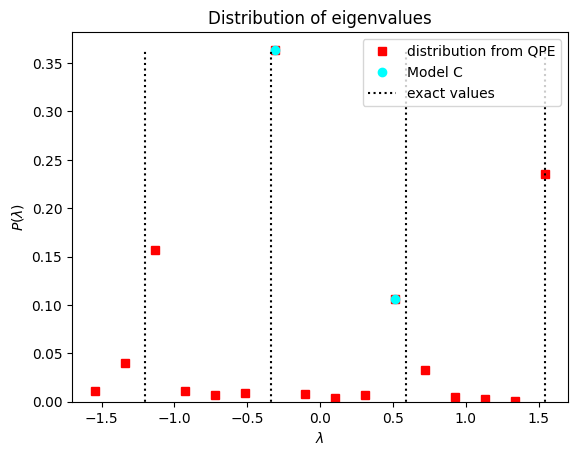

In [17]:
reduced_eigs = (
    np.array(
        [
            np.floor(eig * 2**qpe_reduced_size) / 2**qpe_reduced_size
            for eig in reduced_eig
        ]
    )
    * mat_rescaling ** (-1)
    - mat_shift
)

fix, ax = plt.subplots()

pt2 = ax.plot(original_eigs, eigs_prob, color="red", marker="s", linestyle="None")
pt1 = ax.plot(
    reduced_eigs,
    eigs_prob[eig_maxima_indices][reduced_eig_indices],
    color="cyan",
    marker="o",
    linestyle="None",
)
pt3 = ax.plot([w, w], [[-0.1] * 4, [max(eigs_prob)] * 4], ":k")

ax.set_ylim(0, max(eigs_prob) * 1.05)
ax.set_title("Distribution of eigenvalues")
ax.set_ylabel("$P(\\lambda)$")
ax.set_xlabel("$\\lambda$")
ax.legend(["distribution from QPE", "Model C", "exact values"], loc="upper right")

**Comment: the effect of trimming the LSB cannot be observed from the plot as it is 0 in our case. To see the effect one should look at the distribution of eigenvalues obtained from a QPE of size 3.**

### 5.3. Step 3: A full HHL routine, including a swap test with the classical solution

Let us build the HHL model, setting two outputs:
* `indicator` of size 1. When measured 1 it means the unitary register collapsed to the linear problem solution.
* `test` of size 1. The test qubit of the swap test.

We take the classical solution of the linear problem for the comparison

In [18]:
sol_classical = np.linalg.solve(a_mat, normalized_b_vec)
compared_sol = sol_classical
amp_compared = (compared_sol / np.linalg.norm(compared_sol)).tolist()

In [19]:
@qfunc
def main(indicator: Output[QBit], test: Output[QBit]) -> None:

    state = QArray()
    compared_state = QArray()
    phase_var = QNum()
    allocate(qpe_reduced_size, False, qpe_reduced_size, phase_var)
    prepare_amplitudes(normalized_b_vec, SP_ERROR, state)
    within_apply(
        lambda: qpe(unitary=lambda: unitary(unitary_mat, state), phase=phase_var),
        lambda: reduced_hardcoded_eig_inversion(
            gamma=mat_rescaling ** (-1),
            delta=-mat_shift,
            c_param=w_min,
            eigs=reduced_eig,
            phase=phase_var,
            indicator=indicator,
        ),
    )

    prepare_amplitudes(amp_compared, 0.0, compared_state)
    swap_test(state, compared_state, test)

    drop(state)
    drop(compared_state)
    drop(phase_var)


qmod_feed_forward_hhl = create_model(main)

#### 5.3.1. Synthesizing the quantum model and executing the resulting quantum program

We can pass different constraints and preferences to the synthesis engine. For the demonstration let us assume that we are interested in a quantum circuit with up to `max_width`=12 qubits, and ask for optimization over depth.

In [20]:
constraints = Constraints(
    max_width=12,
    optimization_parameter=OptimizationParameter.DEPTH,
)

qmod_feed_forward_hhl = set_constraints(qmod_feed_forward_hhl, constraints)

For large cases, optimization might be challenging; It is always good to set some timeout for the engine.

In [21]:
preferences = Preferences(
    optimization_timeout_seconds=90,
)
qmod_feed_forward_hhl = set_preferences(qmod_feed_forward_hhl, preferences)

Finally, for the execution preferences we can set the one already defined in step 1.

In [22]:
qmod_feed_forward_hhl = set_execution_preferences(
    qmod_feed_forward_hhl,
    ExecutionPreferences(num_shots=NUM_SHOTS, backend_preferences=backend_preferences),
)

We are now ready for synthesizing and executing our model

In [23]:
qprog_feed_forward_hhl = synthesize(qmod_feed_forward_hhl)
results_C = execute(qprog_feed_forward_hhl).result()

We can visualize the circuit

In [24]:
show(qprog_feed_forward_hhl)

Quantum program link: https://platform.classiq.io/circuit/36pbdaNoPz05TgopRESXMoWLlny


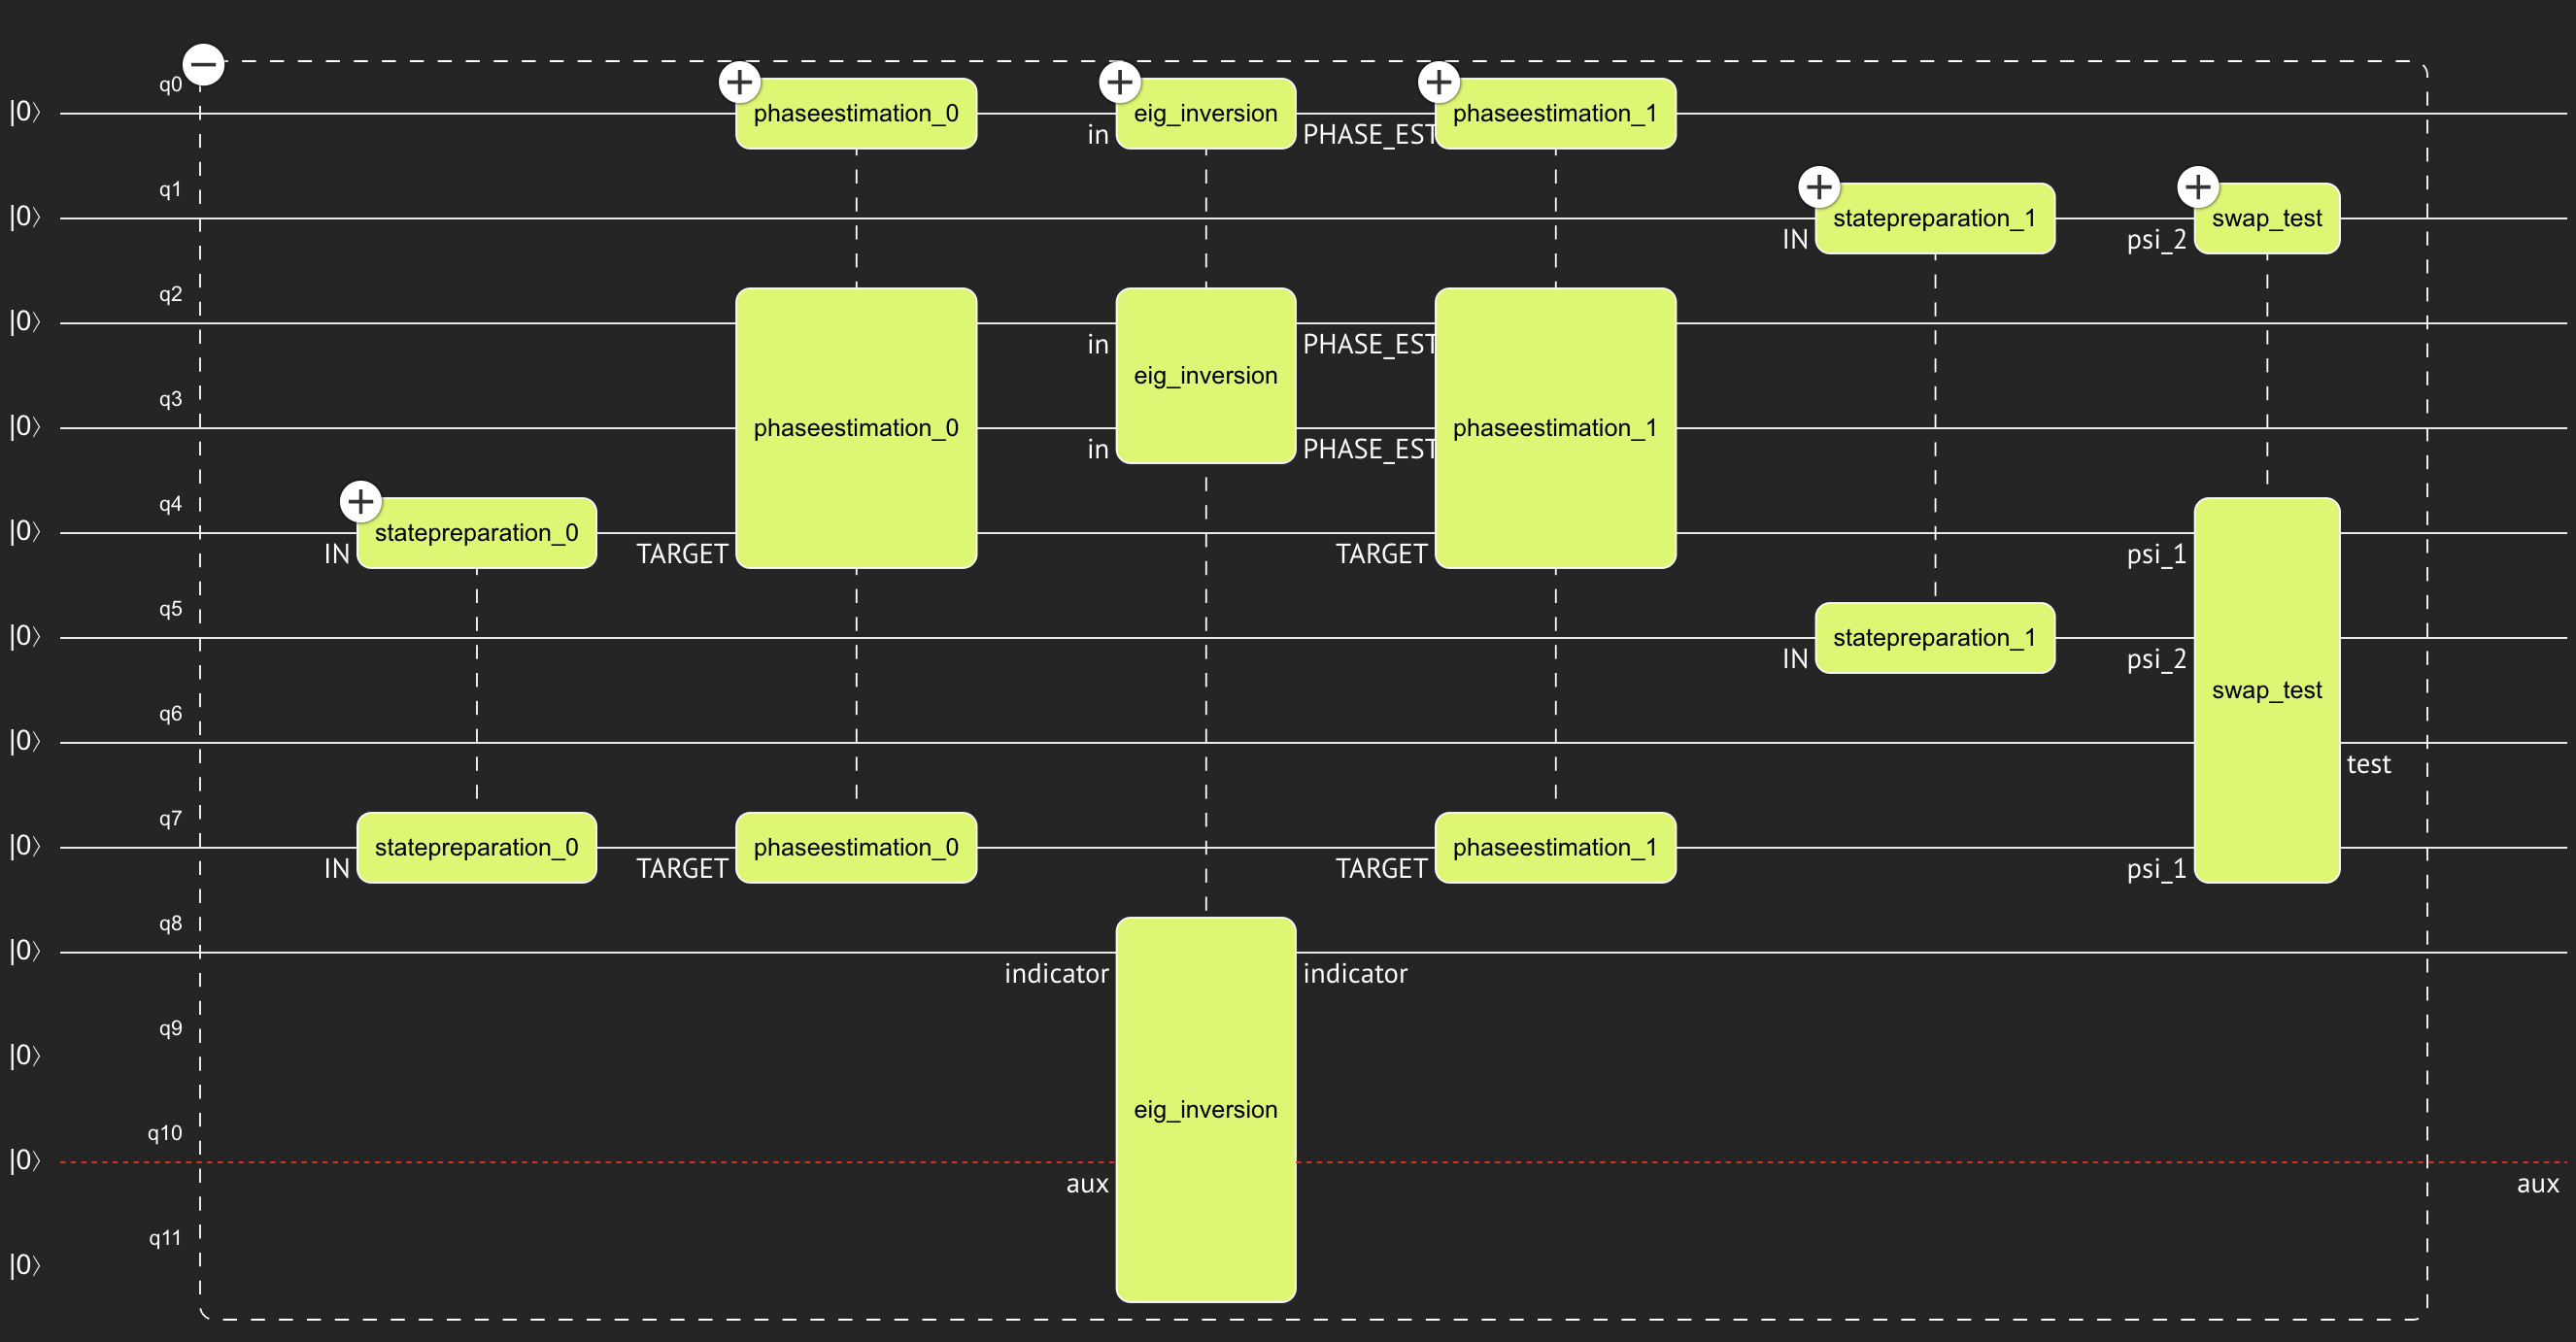

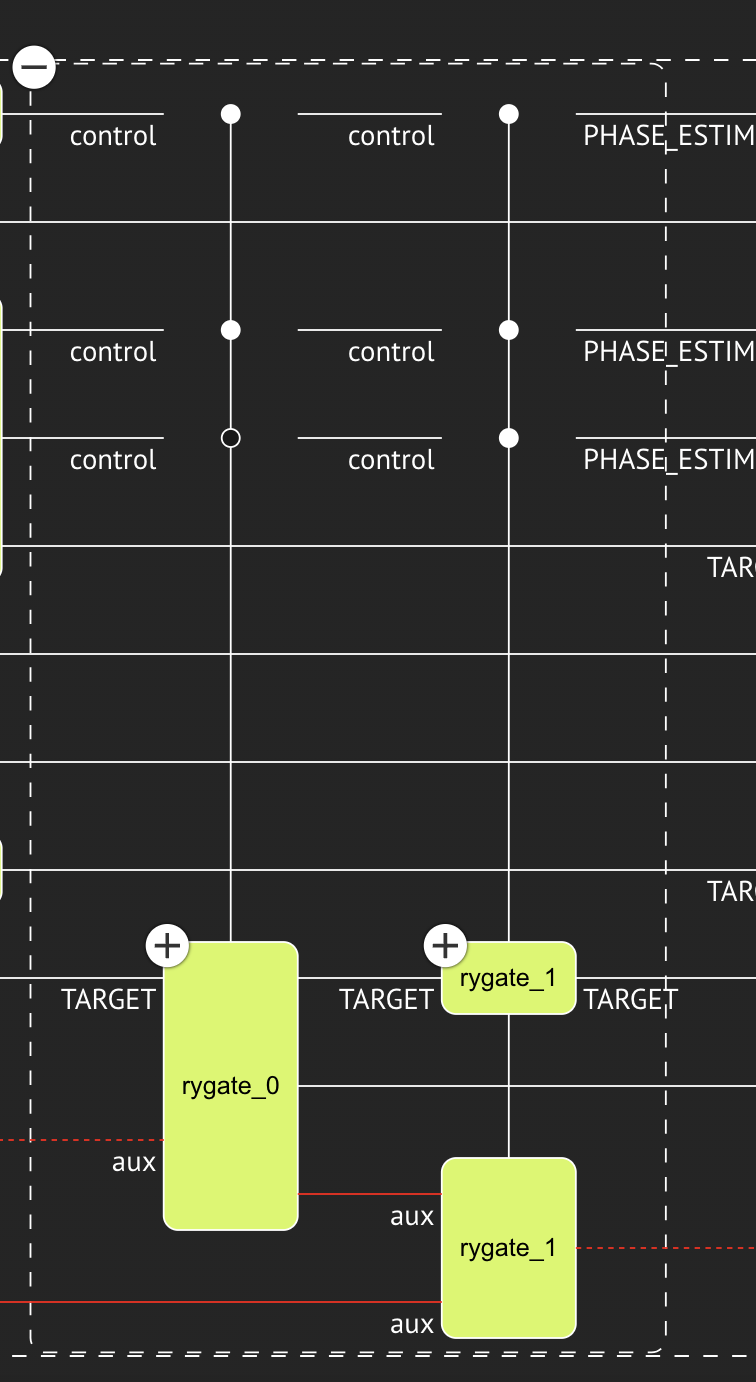

#### 5.3.2. Post-processing the results

Below we post-process the results to find the overlap between the HHL solution and the classical one.
We are interested in the probability of that the test qubit being at state 0, under the condition that the indicator is measured at state 1. Following Eq. (9) we have:

In [25]:
res_hhl = results_C[0].value
fidelity_C = np.sqrt(
    res_hhl.counts_of_multiple_outputs(["indicator", "test"])[("1", "0")]
    * 2
    / (res_hhl.counts_of_output("indicator")["1"])
    - 1
)

print("Fidelity between hybrid HHL and classical solutions:", fidelity_C)

Fidelity between hybrid HHL and classical solutions: 0.9099214192705388


#### 5.3.3. Synthesizing with different constraints

Let us change the constraints and optimize over the number of qubits. This will result in a different circuit

In [26]:
constraints = Constraints(
    optimization_parameter=OptimizationParameter.WIDTH,
)

qmod_hhl_optimized_width = qmod_feed_forward_hhl
qmod_hhl_optimized_width = set_constraints(qmod_hhl_optimized_width, constraints)
qprog_hhl_optimized_width = synthesize(qmod_hhl_optimized_width)
show(qprog_hhl_optimized_width)

Quantum program link: https://platform.classiq.io/circuit/36pbf9f629Td6hHpMb8YO5GRUji


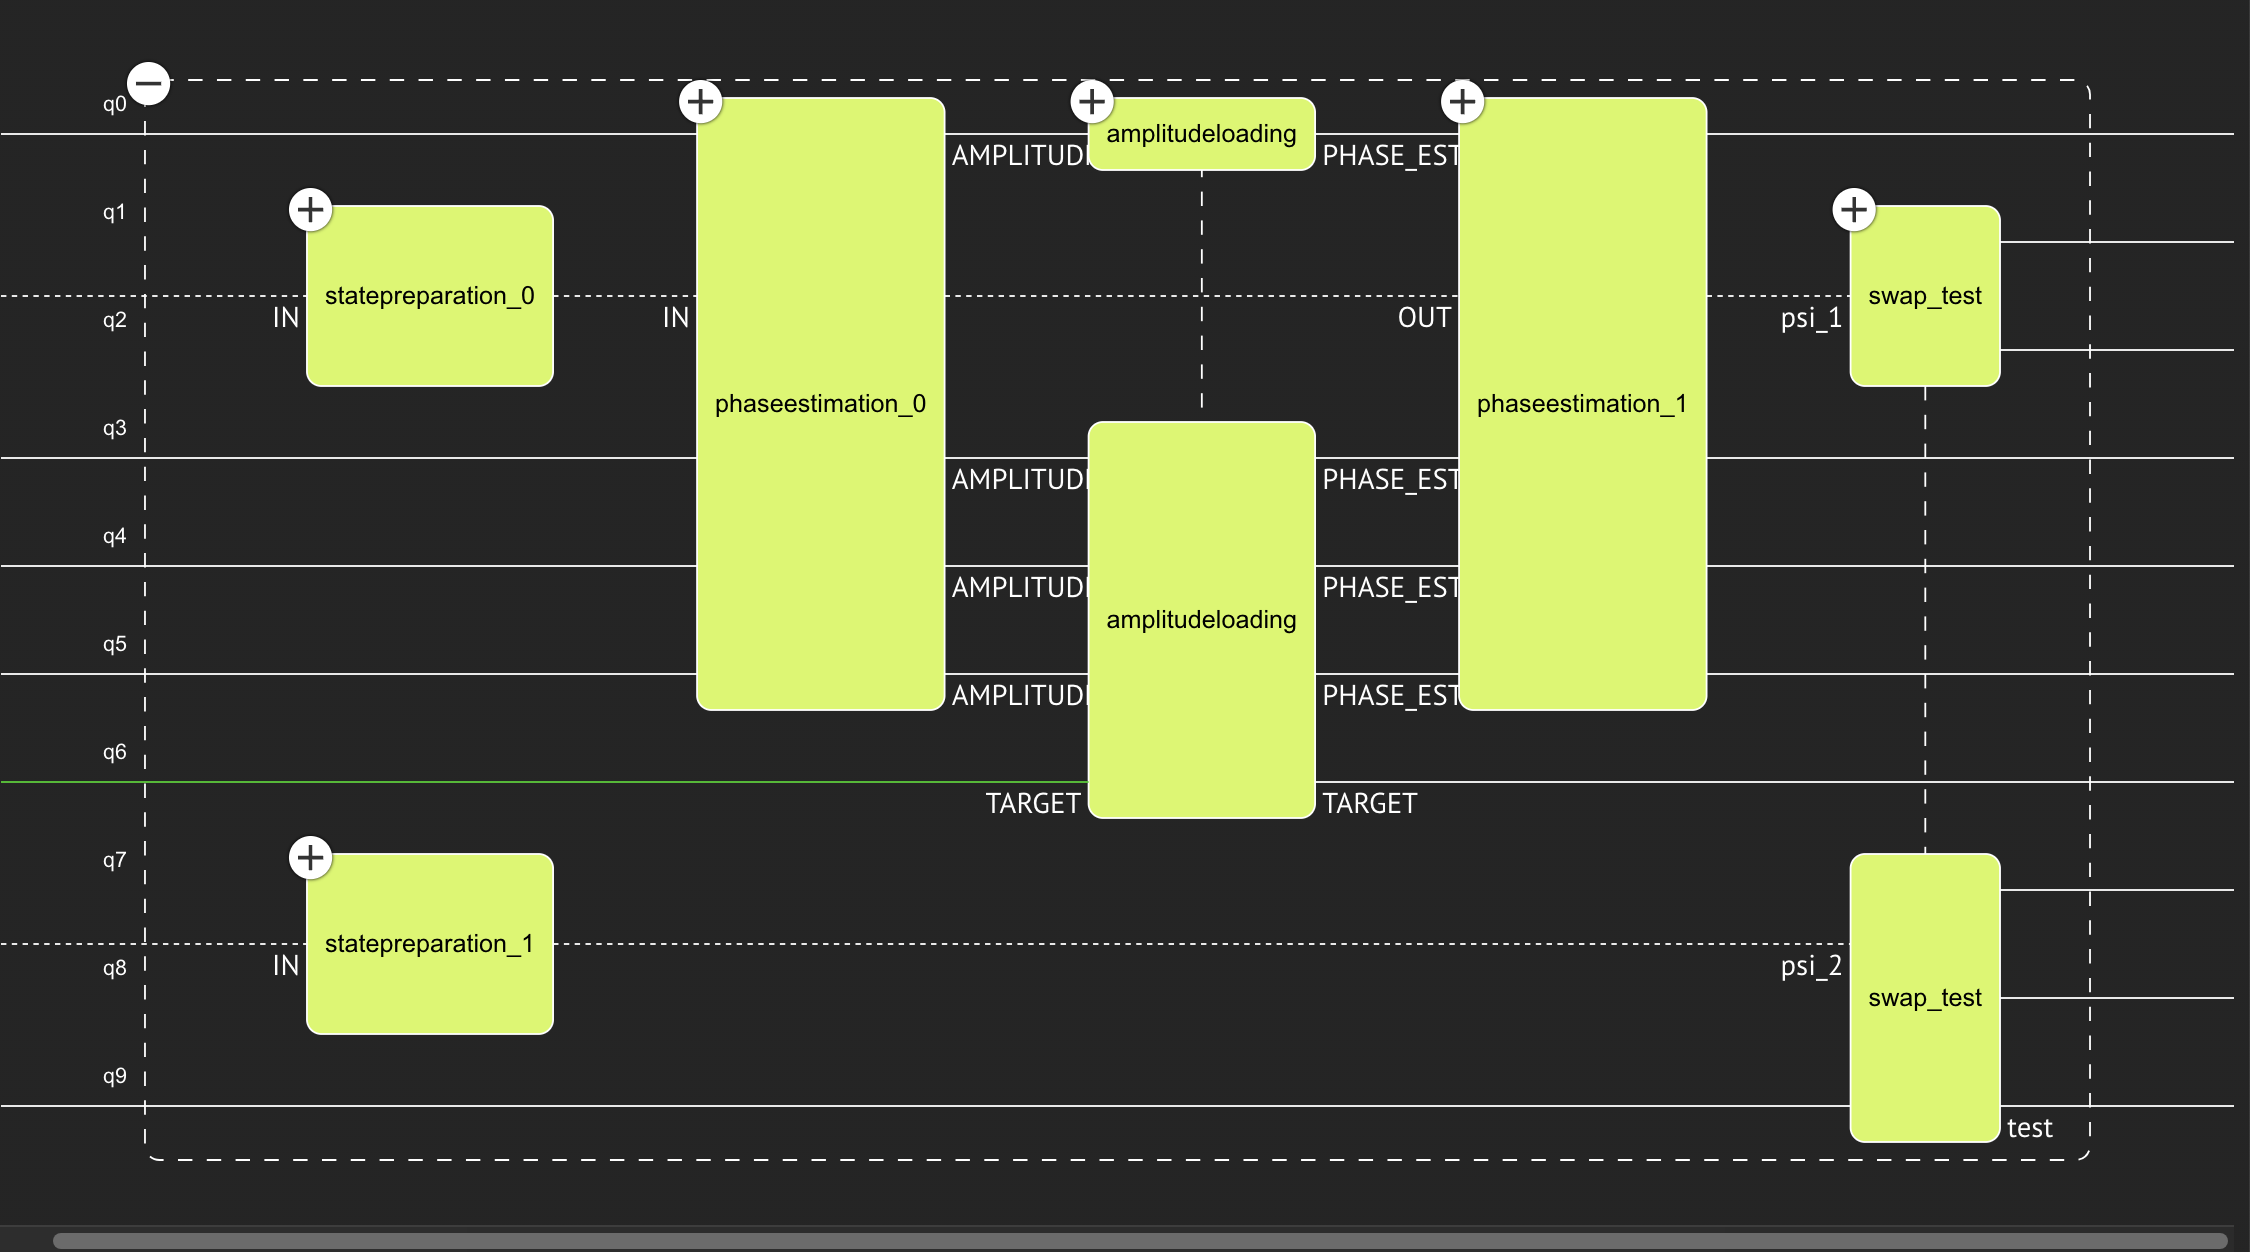

## 6. Comparing with a basic HHL approach

For comparison, below we design, synthesize and execute a a non-hybrid HHL, using the `simple_eig_inversion` function defined in Sec 3.1.

In [27]:
@qfunc
def main(indicator: Output[QBit], test: Output[QBit]) -> None:
    state = QArray()
    compared_state = QArray()
    phase_var = QNum()
    allocate(QPE_SIZE, False, QPE_SIZE, phase_var)
    prepare_amplitudes(normalized_b_vec, SP_ERROR, state)
    within_apply(
        lambda: qpe(unitary=lambda: unitary(unitary_mat, state), phase=phase_var),
        lambda: simple_eig_inv(
            gamma=mat_rescaling ** (-1),
            delta=-mat_shift,
            c_param=w_min,
            phase=phase_var,
            indicator=indicator,
        ),
    )
    prepare_amplitudes(amp_compared, 0.0, compared_state)
    swap_test(state, compared_state, test)
    drop(state)
    drop(compared_state)
    drop(phase_var)


qmod_hhl_basic = create_model(main)
qmod_hhl_basic = set_constraints(qmod_hhl_basic, constraints)
qmod_hhl_basic = set_preferences(qmod_hhl_basic, preferences)
qmod_hhl_basic = set_execution_preferences(
    qmod_hhl_basic,
    ExecutionPreferences(num_shots=NUM_SHOTS, backend_preferences=backend_preferences),
)
qprog_hhl_basic = synthesize(qmod_hhl_basic)
show(qprog_hhl_basic)
results_basic = execute(qprog_hhl_basic).result()

res_hhl_basic = results_basic[0].value
fidelity_basic = np.sqrt(
    res_hhl_basic.counts_of_multiple_outputs(["indicator", "test"])[("1", "0")]
    * 2
    / (res_hhl_basic.counts_of_output("indicator")["1"])
    - 1
)

print("Fidelity between basic HHL and classical solutions:", fidelity_basic)

Quantum program link: https://platform.classiq.io/circuit/36pbg8VpPK9AThkVk6BpgjfDlEj
Fidelity between basic HHL and classical solutions: 0.951661902861773


In [28]:
from classiq import write_qmod

write_qmod(
    qmod_hhl_basic,
    "portfolio_optimization_with_hhl",
    decimal_precision=15,
    symbolic_only=False,
)

## 7. Summary

As a summary, let us collect all the properties of the different circuits we obtained, and plot the results in a table

In [29]:
from classiq import QuantumProgram

depths = list()
widths = list()
cx_counts = list()
fidelities = [fidelity_C, fidelity_C, fidelity_basic]

for qprog in [qprog_feed_forward_hhl, qprog_hhl_optimized_width, qprog_hhl_basic]:
    depths.append(qprog.transpiled_circuit.depth)
    widths.append(qprog.data.width)
    cx_counts.append(qprog.transpiled_circuit.count_ops["cx"])

In [30]:
import pandas as pd

names = ["hyb. HHL C (depth)", "hyb. HHL C (width)", "basic HHL"]

df = pd.DataFrame(
    list(zip(widths, depths, cx_counts, fidelities)),
    columns=["num. qubits", "depth", "cx_count", "fidelity"],
    index=names,
)


df

,num. qubits,depth,cx_count,fidelity
hyb. HHL C (depth),12,416,260,0.909921
hyb. HHL C (width),9,443,268,0.909921
basic HHL,10,477,304,0.951662


Already at this small scale problem we can see reduced properties of the hybrid HHL compared to the basic implementation. This should be more pronounced in larger problems (the properties of the QPE in step 1 of the hybrid approach are not taken into account here).

## 8. Comments

### 8.1 Hamiltonian simulation

As mentioned above, the correct way to implement the unitary on which we apply the QPE is Hamiltonian simulation. One way to apply this quantum function is with the built-in `exponentiation_with_depth_constraint` function. This includes another level of approximation to our algorithm. The exponentiation is implemented with Trotter-Suzuki product. Estimating the functional error of such implementation is a hard problem. An indirect way to manage the error is by increasing the depth of Exponentiation block in order to allow the engine to explore higher order Trotter-Suzuki products. Another option is to use `suzuki_trotter` functions directly. Both functions are then should be plugged it into `qpe` or `qpe_flexible` function, instead of plugging the built-in `unitary`; see [HHL notebook](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb).

### 8.2 Approximating the maximal relevant eigenvalue

In Ref.[[5](#NISQ-HHL)] it was shown how one can use an hybrid quantum-classical routine in order to increase the precision in the eigenvalue resolution in step 1 of the hybrid HHL. The algorithm is based on running this step with various evolution coefficients $\gamma$ in $e^{i\gamma 2\pi A_{\rm qpe}}$, and find the optimal one (in a sense that we increase the resolution in the eigenvalue estimation, while using the same `qpe_size` ).

Note that while this algorithm increases eigenvalue precision it increases the evolution coeffecient, as typically $\gamma>1$. This in turn requires more resources for performing well-approximated Exponentiation.

### 8.3 Using iterative QPE

In Ref.[[5](#NISQ-HHL)] it was shown how one can use an iterative-QPE approach to perform step 1 in the hybrid HHL routine. This allows to get an estimate of the eigenvalues with only one qubit, instead of `qpe_size` qubits.

### 8.4 $\log(\text{Problem size})$ is not an integer

In the problem above we have only 2 assets, which results in a problem with matrix size $2+2=4$. In general, a case of $N$ assets will result in a matrix of size $N+2$ (see Eq. (1)). In case that $\log(N+2)$ is not an integer we can complete the matrix dimension to the closest $2^n$ with an identity matrix. The vector $\vec{b}$ will be completed with zeros.
$$
\begin{pmatrix}
A & 0 \\
0 & I
\end{pmatrix}
\begin{pmatrix}
\vec{b}  \\
0
\end{pmatrix}
=
\begin{pmatrix}
\vec{x}  \\
0
\end{pmatrix}.
$$
This procedure shall not affect the swap-test part, all need to be done is to load a guessed solution as $(\vec{y},0)$.


## References

<a id='PortfolioWiki'>[1]</a>: [Portfolio Optimization (Wikipedia)](https://en.wikipedia.org/wiki/Portfolio_optimization)

<a name='HHL'>[2]</a>: [Harrow, A. W., Hassidim, A., & Lloyd, S., Quantum Algorithm for Linear Systems of Equations. Physical Review Letters 103, 150502 (2009)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.103.150502)

<a name='Hybrid-HHL'>[3]</a>: [Lee Y., Joo J. & Lee S., Hybrid quantum linear equation algorithm and its experimental test on IBM Quantum Experience](https://www.nature.com/articles/s41598-019-41324-9)

<a id='SwapWiki'>[4]</a>: [Swap Test (Wikipedia)](https://en.wikipedia.org/wiki/Swap_test)

<a name='NISQ-HHL'>[5]</a>: [Yalovetzky R., et. al., Hybrid HHL with Dynamic Quantum Circuits on Real Hardware](https://arxiv.org/abs/2110.15958)

